In [ ]:
import urllib.request
yolo_cfg_url="https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov3.cfg"
urllib.request.urlretrieve(yolo_cfg_url,"yolov3.cfg")
import urllib.request
yolo_weights_url="https://pjreddie.com/media/files/yolov3.weights"
urllib.request.urlretrieve(yolo_weights_url,"yolov3.weights")
import urllib.request
coco_names_url="https://raw.githubusercontent.com/AlexeyAB/darknet/master/data/coco.names"
urllib.request.urlretrieve(coco_names_url,"coco.names")

('coco.names', <http.client.HTTPMessage at 0x7976f60a8fd0>)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def load_yolo_model():
  net=cv2.dnn.readNet("yolov3.cfg","yolov3.weights")
  with open("coco.names","r") as f:
    classes=[line.strip() for line in f.readlines()]
  return net,classes

In [ ]:
def detect_objects(image_path, net, classes):
    image = cv2.imread(image_path)
    height, width, channels = image.shape

    # Prepare the image for YOLO
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    output_layers = net.getUnconnectedOutLayersNames()
    outs = net.forward(output_layers)

    # Analyze the outputs
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply non-max suppression
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Draw bounding boxes and count detected objects
    detected_count = len(indexes)
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = (255, 0, 0)
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_PLAIN, 1, color, 2)

    # Save the image with detections
    output_image_path = "detected_image.jpg"
    cv2.imwrite(output_image_path, image)

    return detected_count, output_image_path

In [ ]:
# Load the YOLO model
yolo_net, yolo_classes = load_yolo_model()

In [ ]:
# Example usage
from google.colab import files
uploaded = files.upload()
image_file = next(iter(uploaded))

detected_count, output_image_path = detect_objects(image_file, yolo_net, yolo_classes)
print(f'Number of detected objects: {detected_count}')

Saving 83.png to 83.png
Number of detected objects: 4


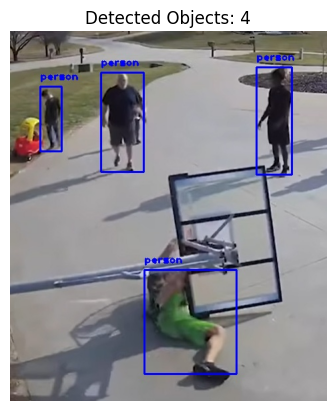

In [ ]:
import matplotlib.pyplot as plt

# Display the image with detections
detected_image = cv2.imread(output_image_path)
plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f'Detected Objects: {detected_count}')
plt.show()